# Phase 2: Running regressions for 1B dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

Bring in dataset:

In [6]:
master_data = pd.read_csv('2_DATA/master_data_B.csv')

In [17]:
master_y = master_data[['beta', 'f']]
master_X = master_data.drop(['Unnamed: 0','FIPS', 'RBIRTH2019', 'POPESTIMATE2019', 'beta', 'f'], axis=1)

A heatmap for the correlation of features:

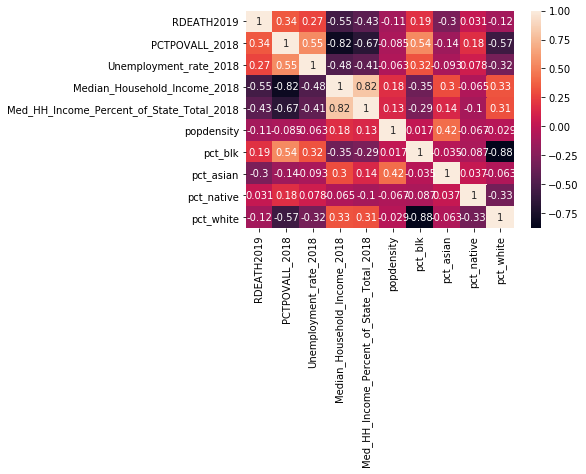

In [18]:
import seaborn as sn

corrMatrix = master_X.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [26]:
master_y['RISK'] = master_y['beta'] + master_y['f'] 
max_risk = np.amax(master_y['RISK'])
master_y['RISK'] = master_y['RISK'] / max_risk * 100

/Users/alexseto/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/alexseto/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split

risk = master_y[['RISK']]
risk.tail()
risk = np.ravel(risk)

# split test set
X, X_test, y, y_test = train_test_split(master_X, risk, random_state = 1, test_size = .2)
print(X.shape, y.shape, X_test.shape, y_test.shape)
# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 1, test_size = 0.25)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)


(739, 10) (739,) (185, 10) (185,)
(554, 10) (554,) (185, 10) (185,)


Following the split of the data, we scale the rest accordingly.

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.fit_transform(X_val)
scaled_X_test = scaler.fit_transform(X_test)
scaled_X = scaler.fit_transform(X)


# LASSO REGRESSION

The MSE is: 186.51050302528947


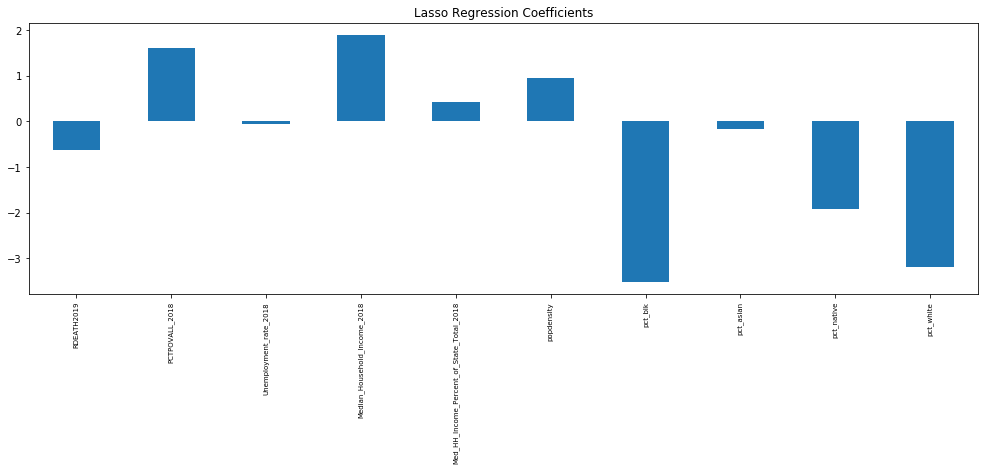

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

lasso = Lasso(alpha = .05)
lasso.fit(scaled_X_train, y_train)
lasso_coefficients = lasso.coef_

lasso_mse = mean_squared_error(y_val, lasso.predict(scaled_X_val))
print('The MSE is:', lasso_mse)

lasso_coefs = pd.Series(lasso.coef_, index=X_train.columns)
plt.figure(figsize=(17, 5))
plt.tick_params(axis='x', labelsize=7)
plt.title("Lasso Regression Coefficients")
lasso_coefs.plot(kind='bar');
plt.show()

lasso_train_score = lasso.score(scaled_X_train, y_train)
lasso_val_score = lasso.score(scaled_X_val, y_val)


In [30]:
print('Train Score: ', lasso_train_score)
print('Validation Score: ', lasso_val_score)
print('Test Score: ', lasso.score(scaled_X_test, y_test))

Train Score:  0.04729411623060642
Validation Score:  0.007948117644407948
Test Score:  -0.003630798354883113


# RANDOM FOREST REGRESSOR

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Enter code is this cell, or add additional cell(s) below.

rf_tree = RandomForestRegressor()
rf_tree.fit(X_train, y_train)

param_dist = {'n_estimators': randint(10, 100),
              'max_leaf_nodes': randint(3, 400),
              'max_features': ["auto"],
              'max_depth': randint(1, 10),
              'min_samples_leaf': randint(1, 30),
              'min_samples_split': randint(2, 20)}

rnd_search = RandomizedSearchCV(rf_tree, param_distributions = param_dist, cv = 10, n_iter = 50)
rnd_search.fit(X_train, y_train)

rf_tree.set_params(n_estimators = rnd_search.best_params_['n_estimators'], 
                   max_leaf_nodes = rnd_search.best_params_['max_leaf_nodes'],                  
                   max_features = rnd_search.best_params_['max_features'],
                   max_depth = rnd_search.best_params_['max_depth'],
                   min_samples_leaf = rnd_search.best_params_['min_samples_leaf'],
                   min_samples_split = rnd_search.best_params_['min_samples_split'])

rf_train_score = rf_tree.score(X_train, y_train)
rf_val_score = rf_tree.score(X_val, y_val)


print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

In [ ]:
importances = rf_tree.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tree.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.show()